In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nqDataLoader as nq #data loading library
from keras.preprocessing import sequence
# np.random.seed(0)
# cnn model
from numpy import mean
from numpy import std
from numpy import dstack
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
# from keras.utils import to_categorical

In [2]:
## importing the early stage dataset 
early_stage = pd.read_csv('GT_DataPD_MIT-CS2PD.csv')
# X = dataset.iloc[:, :-1].values
# y = dataset.iloc[:, -1].values
early_stage["gt"] = early_stage["gt"].astype(int)
early_stage.head()

,pID,gt,updrs108,afTap,sTap,nqScore,typingSpeed,file_1
0,1000,1,27,79.0,184.5,0.107179,56.866667,1424946827.1000_001_014.csv
1,1001,1,16,96.5,189.0,0.056286,118.000000,1427279751.1001_001_014.csv
2,1002,0,5,140.0,158.0,0.039519,119.037037,1426676689.1002_001_014.csv
3,1004,1,22,83.5,191.5,0.034853,74.266667,1429866367.1004_001_014.csv
4,1005,1,17,68.0,150.0,0.048307,74.969697,1430134526.1005_001_014.csv


In [3]:
hit_time_series = []
for index, row in early_stage.iterrows():
    fileloc = row.file_1
    keyPressed, htArr, pressArr, releaseArr =  nq.getDataFiltHelper( "data_MIT-CS2PD/" + early_stage.loc[index]['file_1'])
    htArr =np.array(htArr)
    hit_time_series.append(htArr)

X1 = hit_time_series 

In [4]:
## importing the de-novo dataset 
de_novo = pd.read_csv('GT_DataPD_MIT-CS1PD.csv')
# X = dataset.iloc[:, :-1].values
# y = dataset.iloc[:, -1].values
print(len(de_novo))
de_novo["gt"] = de_novo["gt"].astype(int)
de_novo.head()

31


,pID,gt,updrs108,afTap,sTap,nqScore,typingSpeed,file_1,file_2
0,11,1,14.25,NaN,162.25,0.117543,189.372549,1402930351.011_001_014.csv,1403706430.011_003_014.csv
1,60,0,2.00,NaN,162.25,0.070350,60.533333,1402932300.060_001_014.csv,1403708258.060_003_014.csv
2,67,1,25.25,NaN,133.75,0.223411,54.333333,1401117235.067_001_014.csv,1401978395.067_003_014.csv
3,68,0,6.00,NaN,159.00,0.074973,71.800000,1401114972.068_001_014.csv,1401980765.068_003_014.csv
4,70,1,26.25,NaN,113.50,0.175751,39.614035,1404311419.070_001_014.csv,1404743687.070_003_014.csv


In [5]:
##using both files 
hit_time_series = []
for index, row in de_novo.iterrows():
    fileloc1 = row.file_1
    keyPressed, htArr1, pressArr, releaseArr =  nq.getDataFiltHelper( 'data_MIT-CS1PD/' + de_novo.loc[index]['file_1'])
    htArr1 = np.array(htArr1)
    keyPressed, htArr2, pressArr, releaseArr =  nq.getDataFiltHelper( 'data_MIT-CS1PD/' + de_novo.loc[index]['file_2'])
    htArr2 = np.array(htArr2)
    htArr =np.concatenate((htArr1,htArr2),axis =0)
    htArr=np.array(htArr)
    hit_time_series.append(htArr)
X2 = hit_time_series 

In [6]:
X = np.concatenate((X1,X2),axis=0)
y=  np.concatenate((early_stage['gt'],de_novo["gt"]),axis=0)
print(X.shape)
print(y)

(85,)
[1 1 0 1 1 1 1 1 0 0 0 0 1 0 0 1 1 1 0 0 1 1 1 1 0 0 0 0 0 1 0 1 0 1 0 0 0
 1 0 0 0 1 0 0 0 0 1 0 0 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 0 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 1 0 0 1 1 0]


<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [7]:
import itertools
from sklearn.model_selection import train_test_split
flat_list = list(itertools.chain(*X))
value = sum(flat_list) / len(flat_list)
print(value)
X_padded =sequence.pad_sequences(X,dtype='float32',padding='post',maxlen=6000,value =0)
X_train,X_test,y_train,y_test = train_test_split(X_padded,y,test_size=0.17,random_state=0)


0.11633377817478088


In [8]:


def evaluate_model(trainX, trainy, testX, testy,n_filters):
    verbose, epochs, batch_size = 0, 40, 10
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]
    model = Sequential()
    model.add(Conv1D(filters=n_filters, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=n_filters, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy

>p=8 #1: 76.471
>p=8 #2: 70.588
>p=8 #3: 70.588
>p=8 #4: 70.588
>p=8 #5: 76.471
>p=8 #6: 64.706
>p=8 #7: 76.471
>p=8 #8: 64.706
>p=8 #9: 76.471
>p=8 #10: 58.824
>p=16 #1: 64.706
>p=16 #2: 70.588
>p=16 #3: 70.588
>p=16 #4: 76.471
>p=16 #5: 76.471
>p=16 #6: 70.588
>p=16 #7: 82.353
>p=16 #8: 76.471
>p=16 #9: 76.471
>p=16 #10: 70.588
>p=32 #1: 76.471
>p=32 #2: 70.588
>p=32 #3: 70.588
>p=32 #4: 76.471
>p=32 #5: 76.471
>p=32 #6: 82.353
>p=32 #7: 76.471
>p=32 #8: 82.353
>p=32 #9: 76.471
>p=32 #10: 76.471
>p=64 #1: 76.471
>p=64 #2: 70.588
>p=64 #3: 70.588
>p=64 #4: 82.353
>p=64 #5: 82.353
>p=64 #6: 82.353
>p=64 #7: 76.471
>p=64 #8: 76.471
>p=64 #9: 82.353
>p=64 #10: 70.588
>p=128 #1: 76.471
>p=128 #2: 76.471
>p=128 #3: 76.471
>p=128 #4: 76.471
>p=128 #5: 82.353
>p=128 #6: 76.471
>p=128 #7: 76.471
>p=128 #8: 76.471
>p=128 #9: 70.588
>p=128 #10: 76.471
>p=256 #1: 76.471
>p=256 #2: 82.353
>p=256 #3: 76.471
>p=256 #4: 76.471
>p=256 #5: 76.471
>p=256 #6: 76.471
>p=256 #7: 76.471
>p=256 #8: 70.588
>

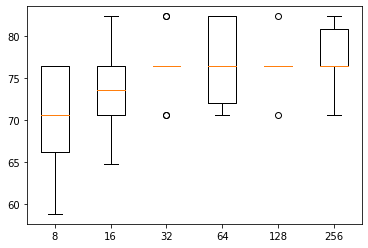

In [9]:
from sklearn.preprocessing import StandardScaler
# run an experiment
def run_experiment(params, repeats=10):
    # load data
    trainX,testX,trainy,testy = train_test_split(X_padded,y,test_size = 0.2,stratify=y)
    trainX = np.array(trainX)
    testX = np.array(testX)
    sc = StandardScaler()
    trainX = sc.fit_transform(trainX)
    trainX = np.reshape(trainX,(trainX.shape[0],trainX.shape[1],1))
    testX = sc.transform(testX)
    testX = np.reshape(testX,(testX.shape[0],testX.shape[1],1))
    # test each parameter
    all_scores = list()
    for p in params:
        # repeat experiment
        scores = list()
        for r in range(repeats):
            score = evaluate_model(trainX, trainy, testX, testy, p)
            score = score * 100.0
            print('>p=%d #%d: %.3f' % (p, r+1, score))
            scores.append(score)
        all_scores.append(scores)
    # summarize results
    summarize_results(all_scores, params)
# summarize scores
def summarize_results(scores, params):
    print(scores, params)
    # summarize mean and standard deviation
    for i in range(len(scores)):
        m, s = mean(scores[i]), std(scores[i])
        print('Param=%d: %.3f%% (+/-%.3f)' % (params[i], m, s))
    # boxplot of scores
    pyplot.boxplot(scores, labels=params)
# run the experiment
n_params = [8, 16, 32, 64, 128, 256]
run_experiment(n_params)

In [10]:
# plot a histogram of each variable in the dataset
def plot_variable_distributions(trainX):
    pyplot.figure()
    xaxis = None
    for i in range(trainX.shape[1]):
        ax = pyplot.subplot(trainX.shape[1], 1, i+1, sharex=xaxis)
        ax.set_xlim(-1, 1)
        if i == 0:
            xaxis = ax
        pyplot.hist(trainX[:, i], bins=100)
    pyplot.show()

In [11]:
# plot_variable_distributions(X_train)

>p=2 #1: 70.588
>p=2 #2: 58.824
>p=2 #3: 58.824
>p=2 #4: 70.588
>p=2 #5: 64.706
>p=2 #6: 70.588
>p=2 #7: 64.706
>p=2 #8: 70.588
>p=2 #9: 64.706
>p=2 #10: 70.588
>p=3 #1: 64.706
>p=3 #2: 58.824
>p=3 #3: 70.588
>p=3 #4: 70.588
>p=3 #5: 47.059
>p=3 #6: 64.706
>p=3 #7: 64.706
>p=3 #8: 64.706
>p=3 #9: 58.824
>p=3 #10: 64.706
>p=5 #1: 70.588
>p=5 #2: 64.706
>p=5 #3: 64.706
>p=5 #4: 58.824
>p=5 #5: 70.588
>p=5 #6: 64.706
>p=5 #7: 47.059
>p=5 #8: 64.706
>p=5 #9: 58.824
>p=5 #10: 58.824
>p=7 #1: 58.824
>p=7 #2: 64.706
>p=7 #3: 58.824
>p=7 #4: 64.706
>p=7 #5: 64.706
>p=7 #6: 47.059
>p=7 #7: 64.706
>p=7 #8: 70.588
>p=7 #9: 58.824
>p=7 #10: 58.824
>p=11 #1: 58.824
>p=11 #2: 64.706
>p=11 #3: 58.824
>p=11 #4: 52.941
>p=11 #5: 64.706
>p=11 #6: 58.824
>p=11 #7: 52.941
>p=11 #8: 64.706
>p=11 #9: 64.706
>p=11 #10: 58.824
[[70.58823704719543, 58.82353186607361, 58.82353186607361, 70.58823704719543, 64.70588445663452, 70.58823704719543, 64.70588445663452, 70.58823704719543, 64.70588445663452, 70.588237047

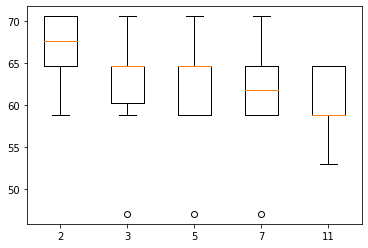

In [15]:
# fit and evaluate a model
def evaluate_model2(trainX, trainy, testX, testy, n_kernel):
    verbose, epochs, batch_size = 0, 40, 10
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]
    model = Sequential()
    model.add(Conv1D(filters=256, kernel_size=n_kernel, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=256, kernel_size=n_kernel, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy
 
# summarize scores
def summarize_results(scores, params):
    print(scores, params)
    # summarize mean and standard deviation
    for i in range(len(scores)):
        m, s = mean(scores[i]), std(scores[i])
        print('Param=%d: %.3f%% (+/-%.3f)' % (params[i], m, s))
    # boxplot of scores
    pyplot.boxplot(scores, labels=params)
    pyplot.savefig('exp_cnn_kernel.png')
 
# run an experiment
def run_experiment(params, repeats=10):
    # load data
    trainX,testX,trainy,testy = train_test_split(X_padded,y,test_size = 0.2,stratify=y)
    trainX = np.array(trainX)
    testX = np.array(testX)
    sc = StandardScaler()
    trainX = sc.fit_transform(trainX)
    trainX = np.reshape(trainX,(trainX.shape[0],trainX.shape[1],1))
    testX = sc.transform(testX)
    testX = np.reshape(testX,(testX.shape[0],testX.shape[1],1))
    # test each parameter
    all_scores = list()
    for p in params:
        # repeat experiment
        scores = list()
        for r in range(repeats):
            score = evaluate_model2(trainX, trainy, testX, testy, p)
            score = score * 100.0
            print('>p=%d #%d: %.3f' % (p, r+1, score))
            scores.append(score)
        all_scores.append(scores)
    # summarize results
    summarize_results(all_scores, params)
 
# run the experiment
n_params = [2, 3, 5, 7, 11]
run_experiment(n_params)

In [30]:
# run an experiment
def run_experiment3(repeats=10):
    # load data

    # repeat experiment
    scores = list()
    for r in range(repeats):
        trainX,testX,trainy,testy = train_test_split(X_padded,y,test_size = 0.2,stratify=y)
        trainX = np.array(trainX)
        testX = np.array(testX)
        sc = StandardScaler()
        trainX = sc.fit_transform(trainX)
        trainX = np.reshape(trainX,(trainX.shape[0],trainX.shape[1],1))
        testX = sc.transform(testX)
        testX = np.reshape(testX,(testX.shape[0],testX.shape[1],1))
        score = evaluate_model3(trainX, trainy, testX, testy)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
    #summarize results
    summarize_results(scores)
 


In [35]:
def evaluate_model3(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 0, 40, 10
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]
    model = Sequential()
    model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy

def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))
    pyplot.boxplot([scores], labels=['CNN with kernel size = 2, n_filters=256, and num_epochs=40'], showmeans=True)
pyplot.show()

>#1: 64.706
>#2: 70.588
>#3: 70.588
>#4: 64.706
>#5: 70.588
>#6: 58.824
>#7: 64.706
>#8: 70.588
>#9: 64.706
>#10: 94.118
[64.70588445663452, 70.58823704719543, 70.58823704719543, 64.70588445663452, 70.58823704719543, 58.82353186607361, 64.70588445663452, 70.58823704719543, 64.70588445663452, 94.11764740943909]
Accuracy: 69.412% (+/-9.037)


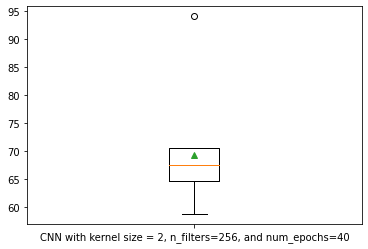

In [36]:
run_experiment3()